0.99228。

In [1]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_file = "../input/train.csv"
test_file = "../input/test.csv"

In [3]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:, 1:], raw_data[:, 0], test_size=0.1)

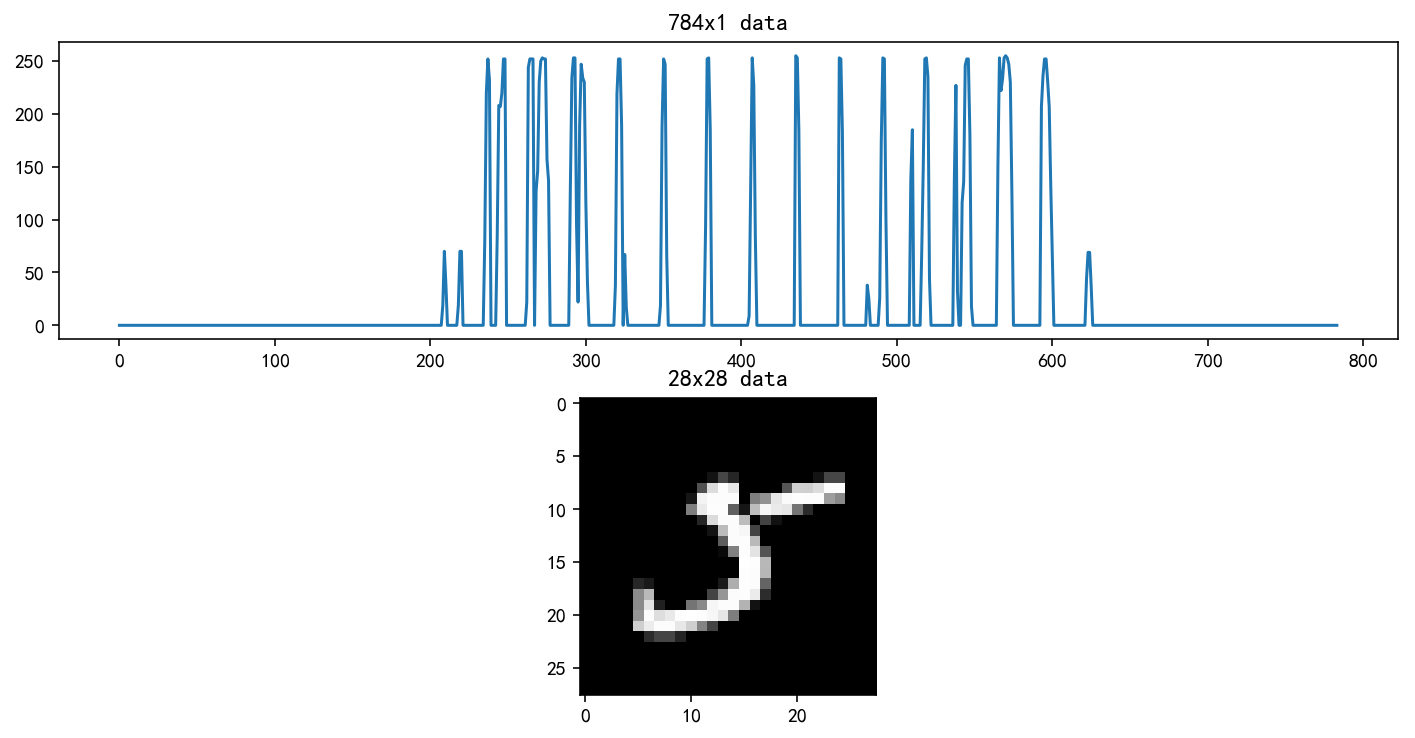

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28, 28), cmap='gray')
ax[1].set_title('28x28 data')
plt.show()

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [7]:
x_train = x_train.astype("float32") / 255.
x_val = x_val.astype("float32") / 255.

In [8]:
from keras.utils.np_utils import to_categorical  # convert to one-hot-encoding

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

Using TensorFlow backend.


## 模型训练

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

model = Sequential()

model.add(
    Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(28, 28, 1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())

model.add(MaxPool2D(strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())

model.add(MaxPool2D(strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        4640      
__________

In [11]:
from keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=["accuracy"])

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10)

In [13]:
from keras.callbacks import LearningRateScheduler

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9**x)

In [14]:
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=16),
    steps_per_epoch=500,
    epochs=20,  #Increase this when not on Kaggle kernel
    verbose=2,  #1 for ETA, 0 for silent
    validation_data=(x_val[:400, :], y_val[:400, :]),  #For speed
    callbacks=[annealer])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 22s - loss: 0.8411 - acc: 0.7304 - val_loss: 0.1652 - val_acc: 0.9500
Epoch 2/20
 - 19s - loss: 0.3459 - acc: 0.8955 - val_loss: 0.0844 - val_acc: 0.9750
Epoch 3/20
 - 20s - loss: 0.2542 - acc: 0.9235 - val_loss: 0.0467 - val_acc: 0.9800
Epoch 4/20
 - 20s - loss: 0.2192 - acc: 0.9393 - val_loss: 0.0655 - val_acc: 0.9800
Epoch 5/20
 - 20s - loss: 0.1998 - acc: 0.9425 - val_loss: 0.0560 - val_acc: 0.9800
Epoch 6/20
 - 20s - loss: 0.1659 - acc: 0.9504 - val_loss: 0.0355 - val_acc: 0.9850
Epoch 7/20
 - 19s - loss: 0.1455 - acc: 0.9576 - val_loss: 0.0313 - val_acc: 0.9850
Epoch 8/20
 - 19s - loss: 0.1384 - acc: 0.9619 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 9/20
 - 21s - loss: 0.1387 - acc: 0.9575 - val_loss: 0.0258 - val_acc: 0.9900
Epoch 10/20
 - 19s - loss: 0.1260 - acc: 0.9643 - val_loss: 0.0136 - val_acc: 1.0000
Epoch 11/20
 - 19s - loss: 0.1106 - acc: 0.9672 - val_loss: 0.0218 - val_acc: 0.9900
Epoch 12/20
 - 27s - loss:

In [15]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
    final_loss, final_acc))

Final loss: 0.0307, final accuracy: 0.9910


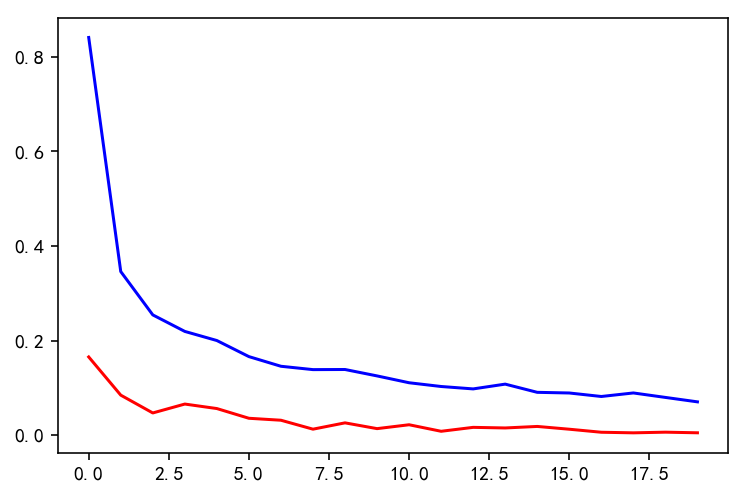

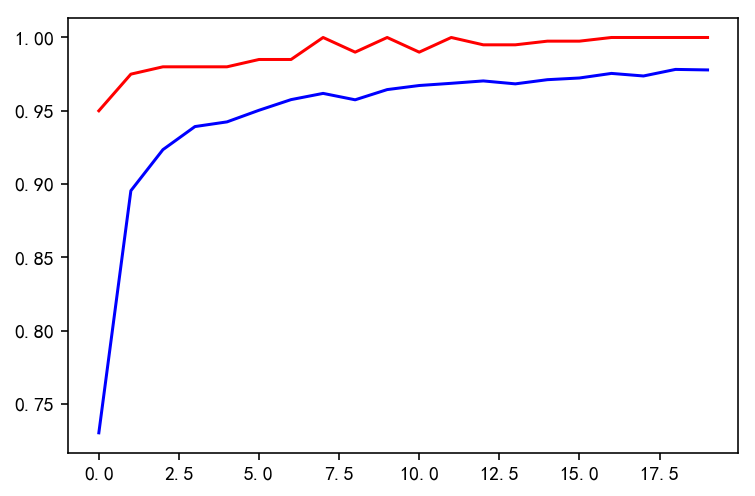

In [16]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[402   0   1   0   0   0   1   0   0   0]
 [  0 459   0   0   1   0   0   1   0   0]
 [  0   0 406   0   0   0   0   0   2   0]
 [  0   0   0 427   0   2   0   0   2   0]
 [  0   0   0   1 403   0   0   0   0   2]
 [  0   0   0   0   0 383   1   0   0   0]
 [  1   0   1   0   0   0 399   0   0   0]
 [  0   0   2   0   1   0   0 472   0   0]
 [  1   0   2   1   2   0   1   1 384   1]
 [  0   1   0   0   5   2   0   1   1 427]]


In [29]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1) / 255.
y_hat = model.predict(x_test, batch_size=64, verbose=2)

In [33]:
y_pred = np.argmax(y_hat, axis=1)
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [22]:
# with open(output_file, 'w') as f:
#     f.write('ImageId,Label\n')
#     for i in range(len(y_pred)):
#         f.write("".join([str(i + 1), ',', str(y_pred[i]), '\n']))

In [41]:
idx = np.arange(1, len(mnist_testset) + 1)

result = pd.DataFrame({'ImageId': idx, 'Label': y_pred})

![image-20190311164507886](https://ws3.sinaimg.cn/large/006tKfTcly1g0yy7arp2zj31lw09ago0.jpg)

In [46]:
output_file = "../output/keras-cnn-bn-submission.csv"

result.to_csv(output_file, index=False)

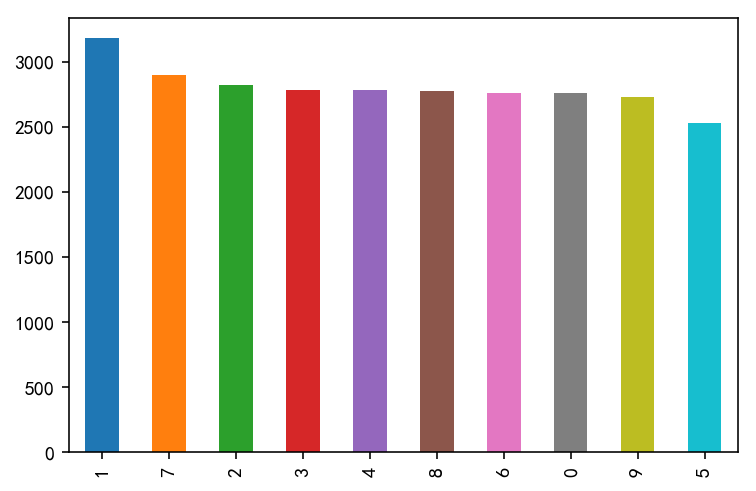

In [43]:
result['Label'].value_counts().plot(kind='bar')
plt.show()